# Model Agnostic Meta Learning Implementation on Indian Sign Language Classification

### Ayush Muralidharan: PES1UG22AM912
### Tejas V Bhat: PES1UG22AM909
### Atharv Revankar: PES1UG22AM920
### Prarthana Kini: PES1UG22AM119

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import libraries for PyTorch, image handling, and data visualization.
Set a fixed random seed for reproducibility.
Detect the available device (CPU/GPU).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from collections import OrderedDict
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
trainframe=pd.read_csv("/content/train_data-2.csv")
testframe=pd.read_csv("/content/test_data-2.csv")

MiniSet: Custom PyTorch dataset class to load images and their labels with transformations applied.
Implements __getitem__ to fetch image-label pairs for training or evaluation tasks.

In [ ]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset class (from your existing code)
class MiniSet(Dataset):
    def __init__(self, fileroots, labels, transform):
        self.fileroots = fileroots
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.fileroots)

    def __getitem__(self, idx):
        img = Image.open(self.fileroots[idx])
        img = self.transform(img)
        return img, self.labels[idx]

In [ ]:
device

device(type='cuda')

Task: Generates training and meta-validation splits (support and query sets) for episodic tasks during meta-training.
TestTask: Similar to Task, but designed for generating test tasks with a separate test dataset.

In [ ]:
class Task(object):
    def __init__(self, all_classes, num_classes, num_instances):
        self.all_classes = all_classes
        self.num_classes = num_classes
        self.num_instances = num_instances
        self.train_roots = []
        self.meta_roots = []
        self.train_labels = []
        self.meta_labels = []

        samples_per_class = 20
        sampled_classes = random.sample(all_classes, num_classes)
        label = 0

        for c in sampled_classes:
            cframe = trainframe.iloc[(c*samples_per_class):((c+1)*samples_per_class)]
            cframe.reset_index(inplace=True, drop=True)
            paths = cframe["Path"]
            sample_idxs = np.random.choice(samples_per_class, samples_per_class, replace=False)
            train_idxs = sample_idxs[:num_instances]
            meta_idxs = sample_idxs[num_instances:(num_instances*2)]

            for idx in train_idxs:
                self.train_roots.append(paths[idx])
                self.train_labels.append(label)
            for idx in meta_idxs:
                self.meta_roots.append(paths[idx])
                self.meta_labels.append(label)
            label += 1
class TestTask(object):
  def __init__(self,all_classes,num_classes,num_instances,num_test_instances):
    self.all_classes=all_classes
    self.num_classes=num_classes
    self.num_instances=num_instances
    self.num_test_instances=num_test_instances
    self.test_roots=[]
    self.train_roots=[]
    self.test_labels=[]
    self.train_labels=[]
    samples_per_class=20
    sampled_classes=random.sample(all_classes,num_classes)
    label=0
    #labels=list(range(len(sampled_classes)))

    for c in sampled_classes:
      cframe=testframe.iloc[((c-15)*samples_per_class):(((c+1)-15)*samples_per_class)]
      cframe.reset_index(inplace=True,drop=True)
      paths=cframe["Path"]
      sample_idxs=np.random.choice(samples_per_class,samples_per_class,replace=False)
      train_idxs=sample_idxs[:num_instances]
      test_idxs=sample_idxs[num_instances:(num_instances+num_test_instances)]
      for idx in test_idxs:
        self.test_roots.append(paths[idx])
        self.test_labels.append(label)
      # for idx in meta_idxs:
      #   self.meta_roots.append(paths[idx])
      #   self.meta_labels.append(label)
      for idx in train_idxs:
        self.train_roots.append(paths[idx])
        self.train_labels.append(label)
      label+=1

ResNetBlock: Implements a basic ResNet block with skip connections. Supports meta-updates by using provided weights during forward passes.

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=1, affine=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=1, affine=True)
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels, momentum=1, affine=True)
            )

    def forward(self, x, weights=None):
        identity = x

        if weights is None:
            out = F.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))

            if len(self.shortcut) > 0:
                identity = self.shortcut(x)

            out += identity
            out = F.relu(out)
        else:
            # Extract layer name from the module path
            for name, module in self.named_modules():
                if module == self.conv1:
                    layer_prefix = name.split('.')[0]
                    break

            prefix = f'meta_learner.features.{layer_prefix}.'

            # Conv1 + BN1
            out = F.conv2d(x, weights[f'{prefix}conv1.weight'],
                          weights.get(f'{prefix}conv1.bias', None),
                          stride=self.conv1.stride,
                          padding=self.conv1.padding)
            out = F.batch_norm(out,
                             weights[f'{prefix}bn1.running_mean'],
                             weights[f'{prefix}bn1.running_var'],
                             weights[f'{prefix}bn1.weight'],
                             weights[f'{prefix}bn1.bias'],
                             momentum=1, training=True)
            out = F.relu(out)

            # Conv2 + BN2
            out = F.conv2d(out, weights[f'{prefix}conv2.weight'],
                          weights.get(f'{prefix}conv2.bias', None),
                          stride=self.conv2.stride,
                          padding=self.conv2.padding)
            out = F.batch_norm(out,
                             weights[f'{prefix}bn2.running_mean'],
                             weights[f'{prefix}bn2.running_var'],
                             weights[f'{prefix}bn2.weight'],
                             weights[f'{prefix}bn2.bias'],
                             momentum=1, training=True)

            # Shortcut
            if len(self.shortcut) > 0:
                identity = F.conv2d(x, weights[f'{prefix}shortcut.0.weight'],
                                  weights.get(f'{prefix}shortcut.0.bias', None),
                                  stride=self.shortcut[0].stride)
                identity = F.batch_norm(identity,
                                      weights[f'{prefix}shortcut.1.running_mean'],
                                      weights[f'{prefix}shortcut.1.running_var'],
                                      weights[f'{prefix}shortcut.1.weight'],
                                      weights[f'{prefix}shortcut.1.bias'],
                                      momentum=1, training=True)

            out += identity
            out = F.relu(out)

        return out

ResNetBase: Builds a ResNet-based backbone model. Contains feature extraction layers and a fully connected classification head.

In [ ]:
class ResNetBase(nn.Module):
    def __init__(self, num_classes):
        super(ResNetBase, self).__init__()
        self.in_channels = 64

        # Modify the initial conv layer to maintain spatial dimensions
        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)),
            ('bn1', nn.BatchNorm2d(64, momentum=1, affine=True)),
            ('relu1', nn.ReLU(inplace=True)),
            ('layer1', self._make_layer(64, 2)),
            ('layer2', self._make_layer(64, 2, stride=1)),  # Changed stride to 1
            ('layer3', self._make_layer(64, 2, stride=1)),  # Changed stride to 1
            ('avgpool', nn.AdaptiveAvgPool2d((1, 1)))
        ]))

        self.fc = nn.Linear(64, num_classes)  # Changed input features to 64

    def _make_layer(self, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(ResNetBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x, weights=None):
        if weights is None:
            out = self.features(x)
            out = out.view(out.size(0), -1)
            out = self.fc(out)
        else:
            out = x
            for name, layer in self.features.named_children():
                if isinstance(layer, ResNetBlock):
                    out = layer(out, weights)
                else:
                    prefix = f'meta_learner.features.{name}.'
                    if isinstance(layer, nn.Conv2d):
                        out = F.conv2d(out, weights[f'{prefix}weight'],
                                     weights.get(f'{prefix}bias', None),
                                     stride=layer.stride,
                                     padding=layer.padding)
                    elif isinstance(layer, nn.BatchNorm2d):
                        out = F.batch_norm(out,
                                         weights[f'{prefix}running_mean'],
                                         weights[f'{prefix}running_var'],
                                         weights[f'{prefix}weight'],
                                         weights[f'{prefix}bias'],
                                         momentum=1, training=True)
                    elif isinstance(layer, nn.ReLU):
                        out = F.relu(out)
                    elif isinstance(layer, nn.AdaptiveAvgPool2d):
                        out = F.adaptive_avg_pool2d(out, (1, 1))

            out = out.view(out.size(0), -1)
            out = F.linear(out, weights['meta_learner.fc.weight'],
                         weights.get('meta_learner.fc.bias', None))

        return F.log_softmax(out, dim=1)

MetaLearner: Wraps the backbone model. Implements the ability to clone the model's parameters and adapt to task-specific updates during meta-learning.

In [ ]:
class MetaLearner(nn.Module):
    def __init__(self, num_classes):
        super(MetaLearner, self).__init__()
        self.meta_learner = ResNetBase(num_classes)
        # Ensure all parameters require gradients
        for param in self.parameters():
            param.requires_grad = True

    def forward(self, x, mod_weights=None):
        if mod_weights is None:
            out = self.meta_learner(x)
        else:
            out = self.meta_learner(x, mod_weights)
        return out

    def clone_state_dict(self):
        cloned_dict = OrderedDict()
        for key, val in self.state_dict().items():
            cloned_dict[key] = val.clone()
        return cloned_dict


Prepares dataloaders for training and meta-validation splits for a task.
get_test_loaders: Prepares dataloaders for evaluation splits (support and query sets) in test tasks.

In [ ]:
def get_loaders(task):
    loaders = {}
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1)
    ])

    trainloader = DataLoader(
        MiniSet(task.train_roots, task.train_labels, transform),
        batch_size=len(task.train_roots),
        shuffle=True
    )
    metaloader = DataLoader(
        MiniSet(task.meta_roots, task.meta_labels, transform),
        batch_size=len(task.meta_roots),
        shuffle=True
    )

    loaders["train"] = trainloader
    loaders["meta"] = metaloader
    return loaders

def get_test_loaders(task):
  loaders={}
  transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1)
    ])
  test_fileroots=task.test_roots
  test_labels=task.test_labels
  train_fileroots=task.train_roots
  train_labels=task.train_labels
  testloader=DataLoader(MiniSet(test_fileroots,test_labels,transform),
                         batch_size=len(test_fileroots),shuffle=True)
  # metaloader=DataLoader(MiniSet(meta_fileroots,meta_labels,transform),
  #                        batch_size=len(meta_fileroots),shuffle=True)
  trainloader=DataLoader(MiniSet(train_fileroots,train_labels,transform),
                         batch_size=len(train_fileroots),shuffle=True)
  loaders["train"]=trainloader
  #loaders["meta"]=metaloader
  loaders["test"]=testloader
  return loaders



Adapts the model to a single task by applying gradient updates to the cloned model using support set data.
Returns the task-specific updated model parameters.

In [ ]:
def train_single_task(net, lr, loaders, num_updates, loss_metric):
    net.train()
    trainloader = loaders["train"]
    x, y = next(iter(trainloader))
    x, y = x.to(device), y.to(device)

    # Ensure the network parameters require gradients
    for param in net.parameters():
        param.requires_grad = True

    # Initialize modified weights
    mod_state_dict = net.clone_state_dict()
    mod_weights = OrderedDict()

    # First forward pass
    output = net(x)
    loss = loss_metric(output, y)

    # Get initial gradients
    grads = torch.autograd.grad(loss, [p for p in net.parameters() if p.requires_grad],
                               create_graph=True, allow_unused=True)

    # Update weights for first step
    for (name, param), grad in zip([(n, p) for n, p in net.named_parameters() if p.requires_grad], grads):
        if grad is not None:
            mod_weights[name] = param - lr * grad
            mod_state_dict[name] = mod_weights[name]
        else:
            mod_weights[name] = param.clone()
            mod_state_dict[name] = param.clone()

    # Perform remaining updates
    for i in range(1, num_updates):
        output = net(x, mod_state_dict)
        loss = loss_metric(output, y)

        # Get gradients for parameters that require gradients
        grads = torch.autograd.grad(
            loss,
            [w for w in mod_weights.values() if w.requires_grad],
            create_graph=True,
            allow_unused=True
        )

        # Update weights
        grad_idx = 0
        for name, param in mod_weights.items():
            if param.requires_grad:
                if grad_idx < len(grads) and grads[grad_idx] is not None:
                    mod_weights[name] = param - lr * grads[grad_idx]
                    mod_state_dict[name] = mod_weights[name]
                grad_idx += 1

    return mod_state_dict

Main meta-training loop.
Iteratively samples tasks, performs task-specific adaptations, and updates the meta-learner's parameters based on query set performance.

In [ ]:
def train(net, meta_train_classes, meta_optimizer, scheduler, loss_metric, num_classes, num_instances,
          num_tasks, lr, meta_lr, num_inner_updates, num_epochs):
    net = net.to(device)
    # Ensure all parameters require gradients
    for param in net.parameters():
        param.requires_grad = True

    total_loss = 0
    best_loss = float('inf')
    print_every = 100
    plot_every = 2
    meta_losses = []
    patience_counter = 0
    patience_limit = 100

    for epoch in range(1, num_epochs + 1):
        state_dicts = []
        loaders_list = []
        meta_optimizer.zero_grad()

        # Compute task-specific adapted parameters
        for n in range(num_tasks):
            task = Task(meta_train_classes, num_classes, num_instances)
            loaders = get_loaders(task)
            d = train_single_task(net, lr, loaders, num_inner_updates, loss_metric)
            state_dicts.append(d)
            loaders_list.append(loaders)

        # Compute meta-loss
        metaloss = 0
        for n in range(num_tasks):
            loaders = loaders_list[n]
            metaloader = loaders["meta"]
            x, y = next(iter(metaloader))
            x, y = x.to(device), y.to(device)
            d = state_dicts[n]
            output = net(x, d)
            loss = loss_metric(output, y)
            metaloss += loss

        metaloss = metaloss / float(num_tasks)
        total_loss += metaloss.item()

        # Update meta-parameters
        metaloss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        meta_optimizer.step()
        meta_optimizer.zero_grad()

        # Learning rate scheduling and logging
        if epoch % print_every == 0:
            current_loss = total_loss / plot_every
            scheduler.step(current_loss)
            print(f"Epoch {epoch}/{num_epochs}. Loss: {current_loss:.4f}")

            if current_loss < best_loss:
                best_loss = current_loss
                patience_counter = 0
                torch.save(net.state_dict(), 'best_meta_resnet_model.pth')
            else:
                patience_counter += 1

            if patience_counter >= patience_limit:
                print("Early stopping triggered!")
                break

        if epoch % plot_every == 0:
            meta_losses.append(total_loss / plot_every)
            total_loss = 0

        if (epoch % 20) == 0:
            print(f"Epoch {epoch} completed.")

    return meta_losses, net


Sets hyperparameters for meta-learning (e.g., number of classes, shots, tasks).
Trains the MetaLearner on training tasks.
Plots meta-loss during training to monitor progress.

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 20 completed.
Epoch 40 completed.
Epoch 60 completed.
Epoch 80 completed.
Epoch 100/1000. Loss: 1.0376
Epoch 100 completed.
Epoch 120 completed.
Epoch 140 completed.
Epoch 160 completed.
Epoch 180 completed.
Epoch 200/1000. Loss: 0.9224
Epoch 200 completed.
Epoch 220 completed.
Epoch 240 completed.
Epoch 260 completed.
Epoch 280 completed.
Epoch 300/1000. Loss: 0.8668
Epoch 300 completed.
Epoch 320 completed.
Epoch 340 completed.
Epoch 360 completed.
Epoch 380 completed.
Epoch 400/1000. Loss: 0.8734
Epoch 400 completed.
Epoch 420 completed.
Epoch 440 completed.
Epoch 460 completed.
Epoch 480 completed.
Epoch 500/1000. Loss: 0.7948
Epoch 500 completed.
Epoch 520 completed.
Epoch 540 completed.
Epoch 560 completed.
Epoch 580 completed.
Epoch 600/1000. Loss: 0.7848
Epoch 600 completed.
Epoch 620 completed.
Epoch 640 completed.
Epoch 660 completed.
Epoch 680 completed.
Epoch 700/1000. Loss: 0.8025
Epoch 700 completed.
Epoch 720 completed.
Epoch 740 completed.
Epoch 760 completed.
Epo

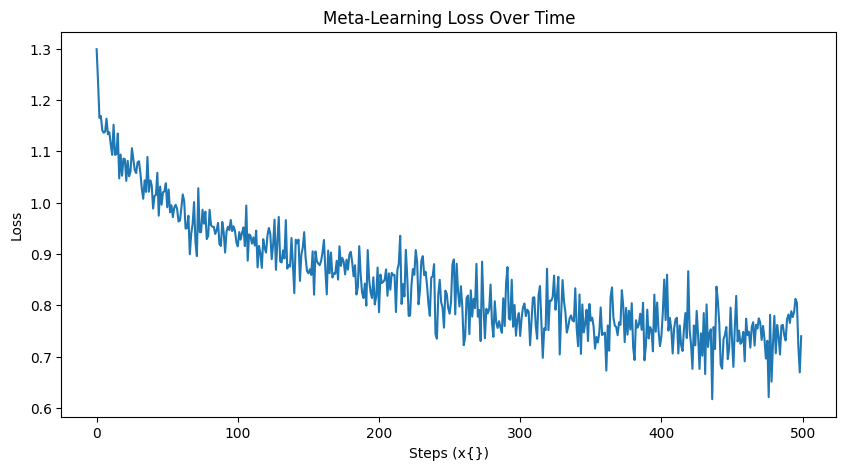

In [ ]:
num_classes = 4
num_instances = 5
num_tasks = 10
lr = 0.1
meta_lr = 0.001
num_inner_updates = 5
num_epochs = 1000
# Initialize network and optimizer
net = MetaLearner(num_classes)
meta_optimizer = optim.Adam(net.parameters(), lr=meta_lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(meta_optimizer, mode='min', factor=0.5, patience=50, verbose=True)
loss_metric = nn.NLLLoss()

# Get training classes
train_classes = np.max(trainframe['Label'])
train_classes = list(np.arange(train_classes))

# Train the model
meta_losses, trained_net = train(
    net, train_classes, meta_optimizer, scheduler, loss_metric,
    num_classes, num_instances, num_tasks, lr, meta_lr,
    num_inner_updates, num_epochs
)

# Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(meta_losses)
plt.title('Meta-Learning Loss Over Time')
plt.xlabel('Steps (x{})')
plt.ylabel('Loss')
plt.show()

# Save the model
torch.save(trained_net.state_dict(), 'meta_resnet_model.pth')

Calculates the accuracy of predictions on the query set.
Tests the trained meta-learner on new tasks. Adapts the model using the support set and evaluates it on the query set.

In [ ]:
def accuracy(predictions, targets):

    pred_classes = np.argmax(predictions, axis=1)
    return np.mean(pred_classes == targets)

def evaluate(net, test_classes, task_lr, num_classes=2, num_steps=500, num_eval_updates=3):

    losses = []
    acc_list = []

    for step in range(num_steps):
        # Create test task
        task = TestTask(test_classes,
                       num_classes=num_classes,
                       num_instances=3,
                       num_test_instances=10)

        # Get loaders for this task
        loaders = get_test_loaders(task)
        trainloader, testloader = loaders["train"], loaders["test"]

        # Get support (train) and query (test) data
        x_train, y_train = next(iter(trainloader))
        x_test, y_test = next(iter(testloader))

        # Move to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        # Clone network for this task
        cloned_net = copy.deepcopy(net)
        cloned_net = cloned_net.to(device)

        # Create optimizer for adaptation
        optim = torch.optim.SGD(cloned_net.parameters(), lr=task_lr)

        # Adapt the model on support set
        for _ in range(num_eval_updates):
            y_train_pred = cloned_net(x_train)
            loss = loss_metric(y_train_pred, y_train)
            optim.zero_grad()
            loss.backward()
            optim.step()

        # Evaluate on query set
        with torch.no_grad():
            y_test_pred = cloned_net(x_test)
            loss = loss_metric(y_test_pred, y_test)
            losses.append(loss.item())

            # Convert predictions and labels to numpy for accuracy calculation
            y_test_pred = y_test_pred.exp().cpu().numpy()  # Convert log_softmax to probabilities
            y_test = y_test.cpu().numpy()
            acc = accuracy(y_test_pred, y_test)
            acc_list.append(acc)

        if (step + 1) % 10 == 0:
            print(f"Step {step + 1}/{num_steps}, "
                  f"Current Accuracy: {acc:.4f}, "
                  f"Average Accuracy: {np.mean(acc_list):.4f}")

    return acc_list, losses



In [ ]:
def evaluate_and_report(net, test_classes, task_lr=0.1, num_classes=2,
                       num_steps=500, num_eval_updates=3):

    print("Starting evaluation...")
    acc_list, losses = evaluate(net, test_classes, task_lr,
                              num_classes, num_steps, num_eval_updates)

    average_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)

    print("\nEvaluation Results:")
    print(f"Average Accuracy: {average_accuracy*100:.2f}%")
    print(f"Standard Deviation: {std_accuracy*100:.2f}%")
    print(f"95% Confidence Interval: "
          f"[{(average_accuracy-1.96*std_accuracy)*100:.2f}%, "
          f"{(average_accuracy+1.96*std_accuracy)*100:.2f}%]")

    # Plot accuracy distribution
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(acc_list, bins=20, edgecolor='black')
    plt.title('Distribution of Task Accuracies')
    plt.xlabel('Accuracy')
    plt.ylabel('Number of Tasks')

    # Plot loss curve
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title('Loss During Evaluation')
    plt.xlabel('Task')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()

    return average_accuracy, std_accuracy, acc_list, losses

Step 10/500, Current Accuracy: 0.4500, Average Accuracy: 0.7500
Step 20/500, Current Accuracy: 0.5500, Average Accuracy: 0.6625
Step 30/500, Current Accuracy: 1.0000, Average Accuracy: 0.7250
Step 40/500, Current Accuracy: 1.0000, Average Accuracy: 0.7450
Step 50/500, Current Accuracy: 0.9000, Average Accuracy: 0.7510
Step 60/500, Current Accuracy: 0.6000, Average Accuracy: 0.7392
Step 70/500, Current Accuracy: 0.9500, Average Accuracy: 0.7186
Step 80/500, Current Accuracy: 0.5000, Average Accuracy: 0.7225
Step 90/500, Current Accuracy: 0.5500, Average Accuracy: 0.7128
Step 100/500, Current Accuracy: 0.9500, Average Accuracy: 0.7075
Step 110/500, Current Accuracy: 0.5500, Average Accuracy: 0.7091
Step 120/500, Current Accuracy: 0.5000, Average Accuracy: 0.6992
Step 130/500, Current Accuracy: 0.9000, Average Accuracy: 0.7012
Step 140/500, Current Accuracy: 1.0000, Average Accuracy: 0.7064
Step 150/500, Current Accuracy: 1.0000, Average Accuracy: 0.7130
Step 160/500, Current Accuracy: 0.

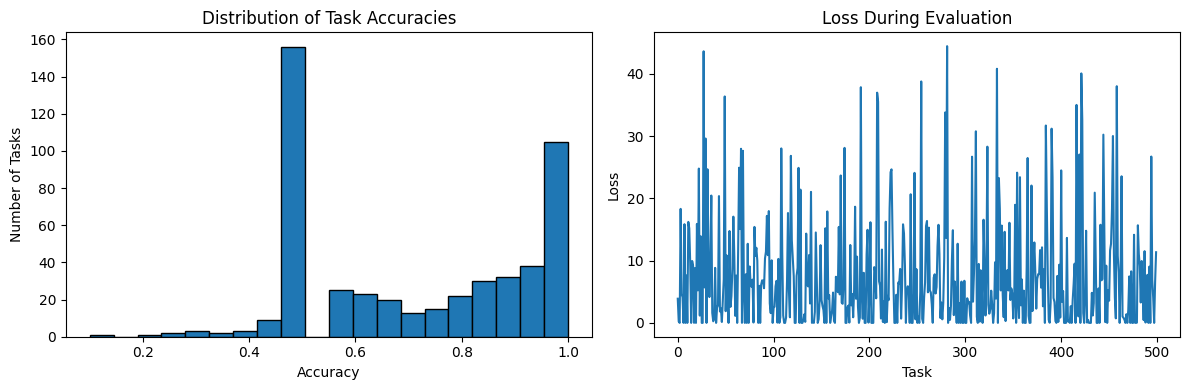

In [ ]:
net = MetaLearner(num_classes)
net.load_state_dict(torch.load('meta_resnet_model.pth',weights_only=True))
net = net.to(device)

# Define test classes
test_classes = list(range(np.min(testframe['Label']), np.max(testframe['Label']) + 1))

# Simple evaluation
acc_list, losses = evaluate(net, test_classes, task_lr=1e-1)
average_test_accuracy = sum(acc_list) / len(acc_list)
print(f"Average Test Accuracy: {average_test_accuracy*100:.2f}%")

# Or use the detailed evaluation with reporting
avg_acc, std_acc, acc_list, losses = evaluate_and_report(
    net,
    test_classes,
    task_lr=1e-1,
    num_classes=2,
    num_steps=500,
    num_eval_updates=3
)